In [1]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import CMR_IA as cmr
import scipy as sp
sns.set_context('paper')
pd.set_option('display.max_columns', None)

In [2]:
with open("../Data/simu5_design.pkl", 'rb') as inp:
    df_study = pickle.load(inp)
    df_test = pickle.load(inp)
# df_study = df_study.loc[df_study.session < 500]
# df_test = df_test.loc[df_test.session < 500]

In [3]:
df_study

,study_itemno1,study_itemno2,study_item1,study_item2,session
0,716,141,HOOP,BLUEJAY,0
1,1261,862,SEAGULL,MAN,0
2,1067,1402,PIKE,SUIT,0
3,146,707,BOLT,HIGHWAY,0
4,155,1140,BOULDER,PUDDLE,0
...,...,...,...,...,...
35995,397,606,CRAB,FRIEND,5999
35996,829,582,LIPSTICK,FLORIDA,5999
35997,1268,394,SENATOR,COWARD,5999
35998,1113,965,POSTAGE,NUT,5999


In [4]:
df_test

,test_itemno,test_item,correct_ans,lag,session
0,716,HOOP,141,5,0
1,736,INDIAN,1342,5,1
2,1217,RUM,318,1,2
3,1119,PREACHER,754,1,3
4,13,AIRPORT,327,0,4
...,...,...,...,...,...
5995,767,JUVENILE,265,5,5995
5996,542,EWE,602,0,5996
5997,1193,RING,732,2,5997
5998,976,OMELET,1569,0,5998


### Run CMR-IA

In [5]:
s_mat = np.load('../Data/wordpools/ltp_FR_similarity_matrix.npy')

In [6]:
params = cmr.make_default_params()
params.update(
    beta_enc = 0.5,
    beta_rec = 0.45,
    beta_rec_post = 0.5,
    gamma_fc = 0.7,
    gamma_cf = 0.5,
    s_fc = 0.1,
    s_cf = 0.1,
    c_thresh = 0.01,
    c_thresh_ass = 0.01,
    a = 2800,
    b = 2.14,
    m = 0,
    n = 1,
    kappa = 0.08,
    lamb = 0.05,
    eta = 0.02,
    phi_s = 1,
    phi_d = 0.6,
    nitems_in_accumulator = 10,
    d_ass = 0.8
)
params

{'beta_enc': 0.5,
 'beta_rec': 0.45,
 'beta_rec_new': 0.5,
 'beta_rec_post': 0.5,
 'beta_distract': None,
 'phi_s': 1,
 'phi_d': 0.6,
 's_cf': 0.1,
 's_fc': 0.1,
 'kappa': 0.08,
 'eta': 0.02,
 'omega': 8,
 'alpha': 4,
 'c_thresh': 0.01,
 'c_thresh_ass': 0.01,
 'd_ass': 0.8,
 'lamb': 0.05,
 'rec_time_limit': 60000.0,
 'dt': 10,
 'nitems_in_accumulator': 10,
 'max_recalls': 50,
 'learn_while_retrieving': False,
 'a': 2800,
 'b': 2.14,
 'm': 0,
 'n': 1,
 'gamma_fc': 0.7,
 'gamma_cf': 0.5}

In [7]:
df_simu, f_in = cmr.run_norm_cr_multi_sess(params,df_study, df_test ,s_mat)
df_simu

CMR Time: 61.90728521347046


,session,test_itemno,s_resp,s_rt
0,0,716,141.0,1560.0
1,1,736,1454.0,2380.0
2,2,1217,318.0,1940.0
3,3,1119,754.0,1680.0
4,4,13,327.0,1730.0
...,...,...,...,...
5995,5995,767,265.0,1730.0
5996,5996,542,602.0,1690.0
5997,5997,1193,94.0,1880.0
5998,5998,976,1569.0,1700.0


In [8]:
df_simu = df_simu.merge(df_test,on=['session','test_itemno'])
df_simu['correct'] = df_simu.s_resp == df_simu.correct_ans
df_simu

,session,test_itemno,s_resp,s_rt,test_item,correct_ans,lag,correct
0,0,716,141.0,1560.0,HOOP,141,5,True
1,1,736,1454.0,2380.0,INDIAN,1342,5,False
2,2,1217,318.0,1940.0,RUM,318,1,True
3,3,1119,754.0,1680.0,PREACHER,754,1,True
4,4,13,327.0,1730.0,AIRPORT,327,0,True
...,...,...,...,...,...,...,...,...
5995,5995,767,265.0,1730.0,JUVENILE,265,5,True
5996,5996,542,602.0,1690.0,EWE,602,0,True
5997,5997,1193,94.0,1880.0,RING,732,2,False
5998,5998,976,1569.0,1700.0,OMELET,1569,0,True


In [9]:
# f_in

In [10]:
sessions = df_simu.session.to_numpy()
for sess in sessions:
    df_tmp = df_study.loc[df_study.session == sess]
    tmp1 = df_tmp.study_itemno1.to_numpy()
    tmp2 = df_tmp.study_itemno2.to_numpy()
    tmp = np.concatenate((tmp1, tmp2))
    tmp = np.sort(tmp)
    testid = np.searchsorted(tmp, df_simu.test_itemno[sess].item())
    corrid = np.searchsorted(tmp, df_simu.correct_ans[sess].item())
    df_simu.loc[df_simu.session == sess, 'corr_fin']= f_in[sess][corrid]
    df_simu.loc[df_simu.session == sess, 'omean_fin'] = np.mean(np.delete(f_in[sess], [testid,corrid]))
    df_simu.loc[df_simu.session == sess, 'omax_fin'] = np.delete(f_in[sess], [testid,corrid]).max()
df_simu

,session,test_itemno,s_resp,s_rt,test_item,correct_ans,lag,correct,corr_fin,omean_fin,omax_fin
0,0,716,141.0,1560.0,HOOP,141,5,True,0.557839,0.451265,0.584270
1,1,736,1454.0,2380.0,INDIAN,1342,5,False,0.541616,0.438663,0.565431
2,2,1217,318.0,1940.0,RUM,318,1,True,0.682296,0.413085,0.600074
3,3,1119,754.0,1680.0,PREACHER,754,1,True,0.679202,0.416056,0.604871
4,4,13,327.0,1730.0,AIRPORT,327,0,True,0.739596,0.381068,0.559108
...,...,...,...,...,...,...,...,...,...,...,...
5995,5995,767,265.0,1730.0,JUVENILE,265,5,True,0.532444,0.435744,0.579219
5996,5996,542,602.0,1690.0,EWE,602,0,True,0.752342,0.377886,0.558455
5997,5997,1193,94.0,1880.0,RING,732,2,False,0.631743,0.447011,0.608025
5998,5998,976,1569.0,1700.0,OMELET,1569,0,True,0.763247,0.391046,0.578000


In [11]:
df_fin = df_simu.groupby('lag')['corr_fin','omean_fin','omax_fin'].mean().reset_index()
df_fin['dif'] = df_fin['corr_fin'] - df_fin['omax_fin']
df_fin

/home1/beigejin/.conda/envs/jinbeige/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,lag,corr_fin,omean_fin,omax_fin,dif
0,0,0.735652,0.378370,0.557311,0.178341
1,1,0.685537,0.418363,0.612873,0.072664
2,2,0.636000,0.446841,0.599250,0.036750
3,3,0.588972,0.462067,0.588383,0.000589
4,4,0.551258,0.461024,0.577777,-0.026518
5,5,0.536775,0.435718,0.567675,-0.030900


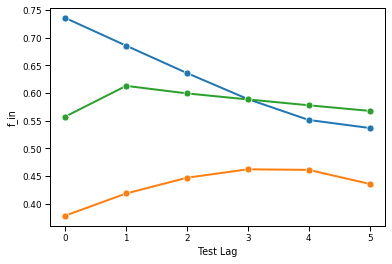

In [12]:
sns.lineplot(data=df_fin, x='lag', y='corr_fin', linewidth=2, marker='o', markersize = 7)
sns.lineplot(data=df_fin, x='lag', y='omean_fin', linewidth=2, marker='o', markersize = 7)
sns.lineplot(data=df_fin, x='lag', y='omax_fin', linewidth=2, marker='o', markersize = 7)
# plt.ylim([0,1])
plt.xlabel('Test Lag')
plt.ylabel('f_in')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

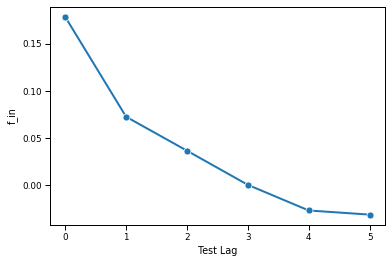

In [13]:
sns.lineplot(data=df_fin, x='lag', y='dif', linewidth=2, marker='o', markersize = 7)
# plt.ylim([0,1])
plt.xlabel('Test Lag')
plt.ylabel('f_in')
# plt.savefig('fig/simu3_hr.pdf')
plt.show()

### PLOT

In [14]:
df_laggp = df_simu.groupby(['lag']).correct.mean().to_frame(name='corr_rate').reset_index()
df_laggp

,lag,corr_rate
0,0,0.834990
1,1,0.497556
2,2,0.358000
3,3,0.258712
4,4,0.173399
5,5,0.193261


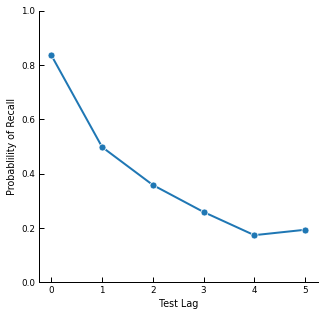

In [15]:
fig,ax = plt.subplots(figsize=(5,5))
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_laggp, x='lag', y='corr_rate', linewidth=2, marker='o', markersize = 7)
plt.ylim([0,1])
plt.xlabel('Test Lag')
plt.ylabel('Probablility of Recall')
plt.savefig('fig/simu5_recall.pdf')
plt.show()